<a href="https://www.kaggle.com/code/siddp6/air-passengers-monthly-prediction-using-arima?scriptVersionId=140381955" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict


from datetime import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/kaggle/input/air-passengers/AirPassengers.csv')
data.info()
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB
       Month  #Passengers
0    1949-01          112
1    1949-02          118
2    1949-03          132
3    1949-04          129
4    1949-05          121
..       ...          ...
139  1960-08          606
140  1960-09          508
141  1960-10          461
142  1960-11          390
143  1960-12          432

[144 rows x 2 columns]


## Finding d

In [4]:
d = 0
p_value = adfuller(data['#Passengers'])[1]
diff_data = data['#Passengers']

while p_value > 0.05:
    diff_data = diff_data.diff()
    p_value = adfuller(diff_data.dropna())[1]
    d += 1

    
print(f'P Value: {p_value}\t Number of differencing needed: {d - 1}')

P Value: 2.7328918500142026e-29	 Number of differencing needed: 1


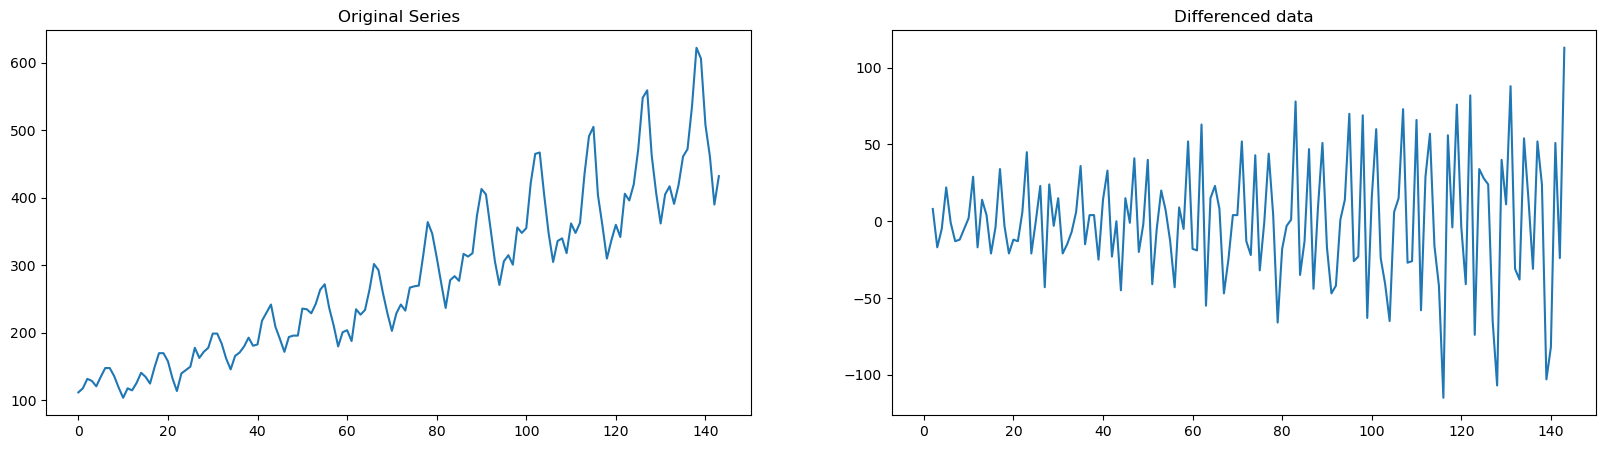

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
axes[0].plot(data['#Passengers']); axes[0].set_title('Original Series')
axes[1].plot(diff_data); axes[1].set_title('Differenced data')
plt.show()


# Finding p

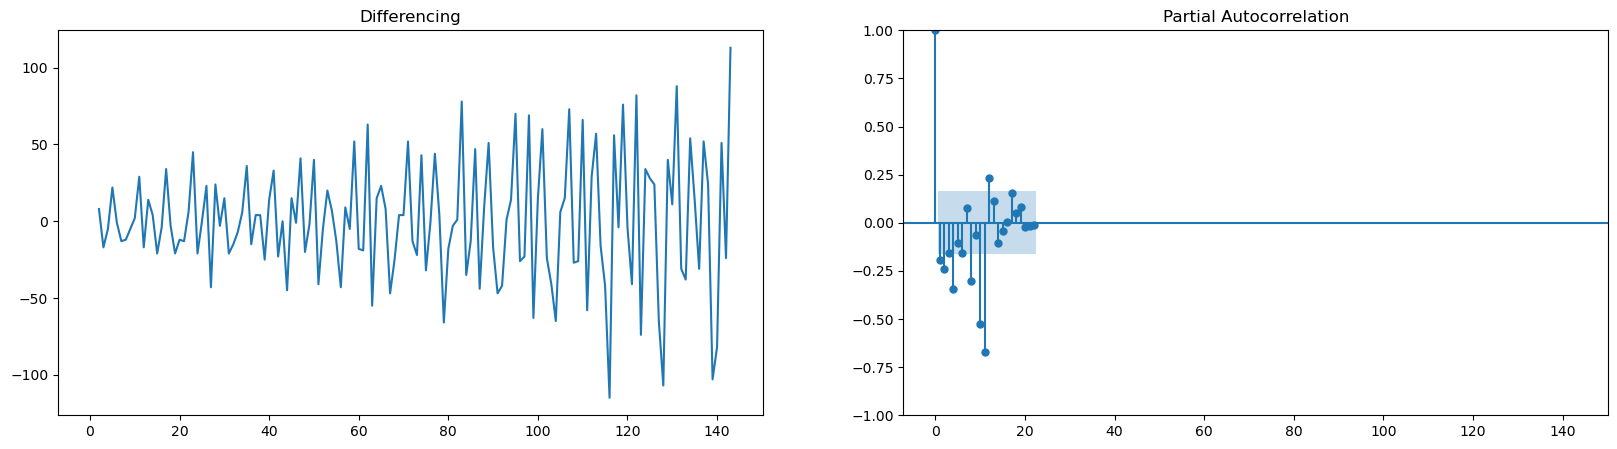

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
axes[0].plot(diff_data); axes[0].set_title('Differencing')
plot_pacf(diff_data.dropna(), ax=axes[1])
plt.show()


# Finding q

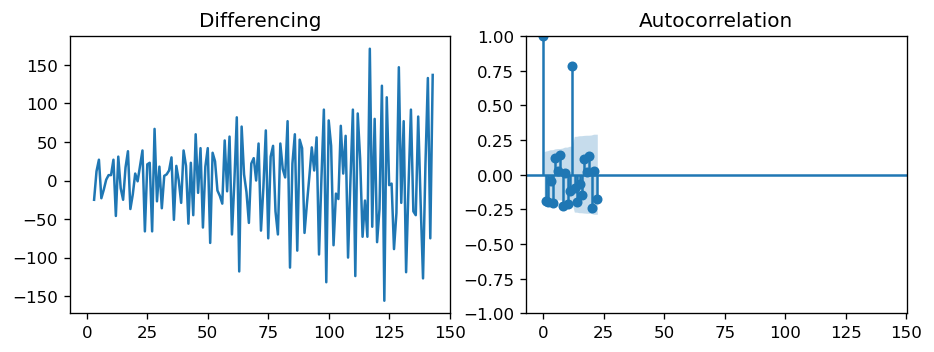

In [7]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff_data.diff()); axes[0].set_title('Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(diff_data.dropna(), ax=axes[1])

plt.show()

# Model

In [8]:
model = ARIMA(data['#Passengers'].values, order=(6,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(6, 2, 1)   Log Likelihood                -684.076
Date:                Sat, 19 Aug 2023   AIC                           1384.151
Time:                        13:31:21   BIC                           1407.798
Sample:                             0   HQIC                          1393.760
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3168      0.106      3.002      0.003       0.110       0.524
ar.L2         -0.2642      0.077     -3.412      0.001      -0.416      -0.112
ar.L3         -0.0764      0.072     -1.061      0.2

In [9]:
model = ARIMA(data['#Passengers'].values, order=(4,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(4, 2, 0)   Log Likelihood                -704.853
Date:                Sat, 19 Aug 2023   AIC                           1419.706
Time:                        13:31:21   BIC                           1434.485
Sample:                             0   HQIC                          1425.712
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3496      0.095     -3.668      0.000      -0.536      -0.163
ar.L2         -0.4159      0.095     -4.396      0.000      -0.601      -0.230
ar.L3         -0.2744      0.070     -3.902      0.0

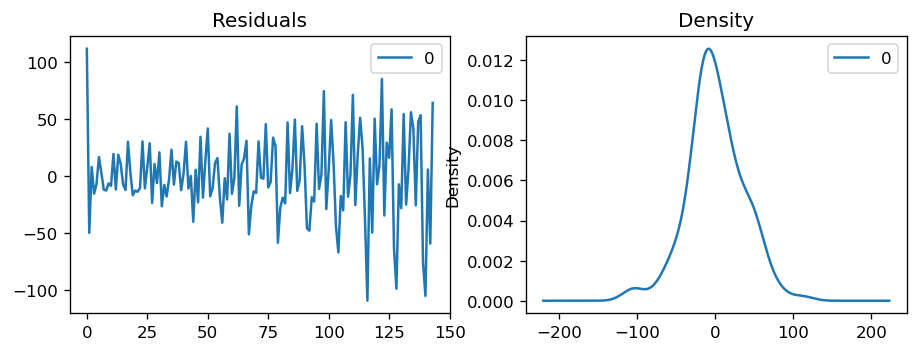

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [11]:
##prediction
pred_start_date=data['Month'].index[0]
pred_end_date=data['Month'].index[-1]
print(pred_start_date)
print(pred_end_date)

pred=model_fit.predict(start=pred_start_date,end=pred_end_date)
data['Predicted_ARIMA']=pred

0
143


<Axes: >

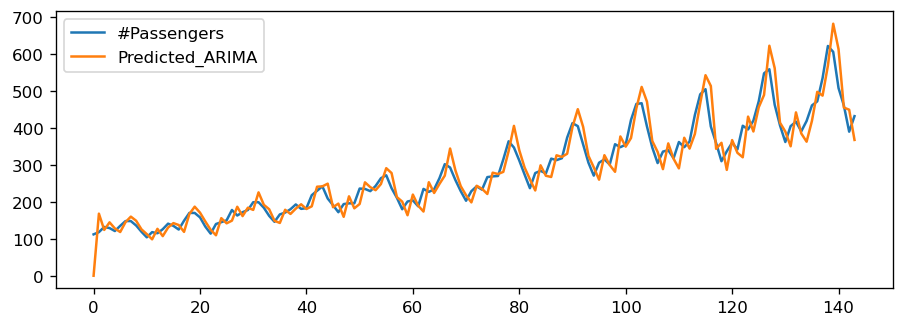

In [12]:
data[['#Passengers','Predicted_ARIMA']].plot()

<Figure size 1200x720 with 0 Axes>

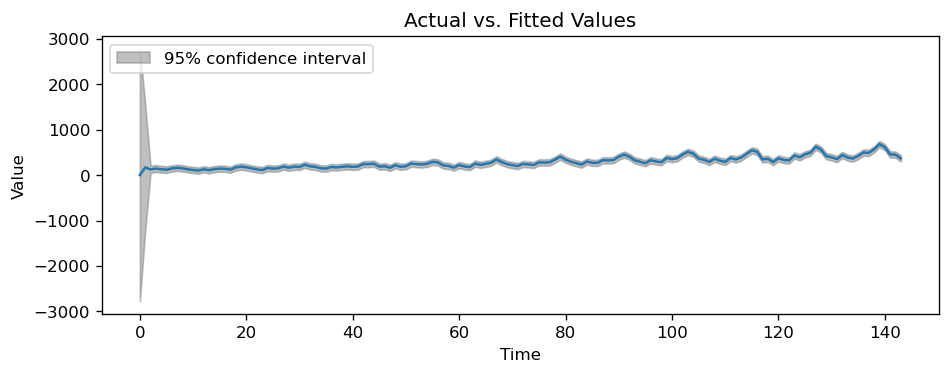

In [13]:
# Plot actual vs. fitted values
plt.figure(figsize=(10, 6))
plot_predict(model_fit, dynamic=False)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Fitted Values')
plt.legend(loc='upper left')
plt.show()

In [14]:
# Define the number of steps to forecast
forecast_steps = 10

# Forecast future values
forecast = model_fit.forecast(steps=forecast_steps)

# Create a range of future dates
date_range = pd.date_range(start=data['Month'].iloc[-1], periods=forecast_steps + 1, freq='MS')[1:]

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'Month': date_range, 'forecast': forecast})

# Merge the forecasted values with the original data
data = pd.concat([data, forecast_df], ignore_index=True)

<Axes: >

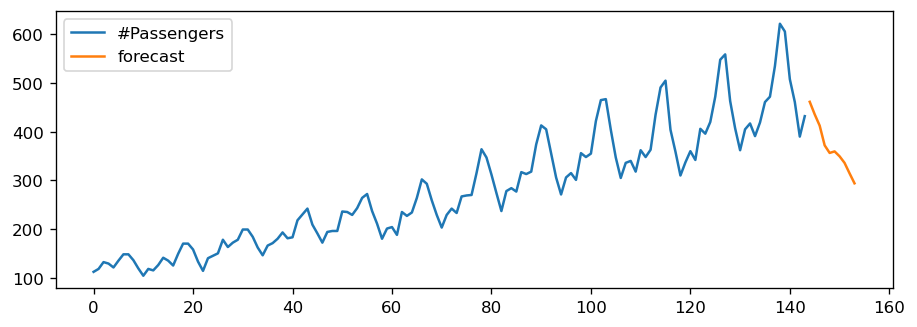

In [15]:
data[['#Passengers','forecast']].plot()